In [2]:
import numpy as np
import matplotlib.pyplot as plt
from classes.ns import NeutronStar
import multiprocess as mp
from classes.axionstar import AxionStar
from classes.minicluster import AxionMiniclusterNFW
from classes.particles import Particles
from scripts.orbits import evolve
from scripts.basic_functions import output_dir

plt.rcParams['figure.figsize'] = [24, 16]

In [3]:
if __name__ == '__main__':
    mp.freeze_support()
    ncores = mp.cpu_count() - 1
    pool = mp.Pool(ncores)

    M_NS, R_NS = 1, 10
    NS = NeutronStar(M_NS, R_NS)

    vy_in = -200.
    M_AS = 1
    AS = AxionStar(M_AS, Particles.axionmass)
    b = AS.radius99()
    AS.center, AS.vcenter = [b, 1e16, 0], [0, vy_in, 0]

    M_MC = 1
    MC = AxionMiniclusterNFW(M_MC, Particles.axionmass, vdisp_type='Maxwell-Boltzmann')
    b = 0.2*MC.radius_trunc()
    MC.center, MC.vcenter = [b, 1e16, 0], [0, vy_in, 0]

    chosen_clump = MC
    nparticles, batch_size, conservation_check = int(1e5), 100, False
    event, conservation_checks = evolve(NS, chosen_clump, pool, nparticles, batch_size=batch_size, conservation_check = conservation_check)

In [4]:
part_trajs = np.load(output_dir + event + '/' + event + '.npy')
nparticles = int(part_trajs[-1][0]) + 1

readme = open(output_dir + event + '/README.txt', 'a')
readme.write('Number of saved trajectories: ' + str(nparticles) + '\n')
if conservation_check:
    readme.write('Energy and angular momentum conservation was checked. It is valid up to ' + str(np.round(np.max(conservation_checks), 2)) + ' percent.')
else:
    readme.write('Energy and angular momentum conservation was not checked.')
readme.close()

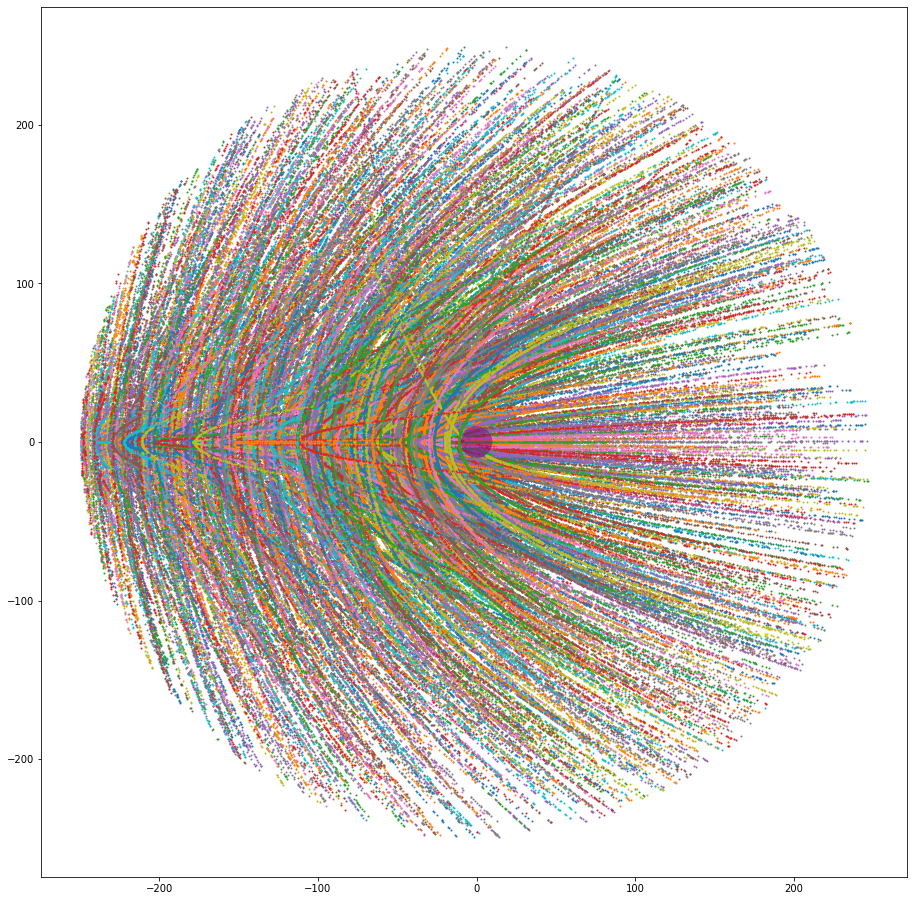

In [23]:
ax = plt.gca()
ax.set_aspect('equal')
nsamples = np.min([int(1e3), nparticles])
part_trajs_cut = part_trajs[:int(nsamples*float(len(part_trajs))/nparticles)]
for i in np.arange(nsamples):
    traj_chosen = np.array([[part_traj[3], part_traj[2]] for part_traj in part_trajs_cut if part_traj[0] == i]).T
    ax.scatter(traj_chosen[0], traj_chosen[1], s = 1)

NS = NeutronStar(M_NS, R_NS)
circle1 = plt.Circle((0, 0), NS.radius, facecolor='purple', alpha = 0.5)
ax.add_patch(circle1)
ax.set_aspect('equal')

plt.savefig(output_dir + event + '/' + event + '.png')